In [1]:
#!pip install economic-complexity
#!pip install pandas pyreadstat
import pyreadstat
import economic_complexity as ecplx
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## In this notebook I calculated the ECI for 2018, using data from 2016, 2017 and 2018

##### First I import the data and concatenate the 3 years

In [2]:
import zipfile
import pandas as pd

# Define the path to your zip file
zip_file_path = 'h4data.zip'

# Initialize an empty DataFrame to store the data
combined_df = pd.DataFrame()

# List of file names
dta_file_names = [
    'country_partner_hsproduct4digit_year_2016.dta',
    'country_partner_hsproduct4digit_year_2017.dta',
    'country_partner_hsproduct4digit_year_2018.dta'
]

# Open the zip file, read each .dta file, and concatenate them
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    for dta_file_name in dta_file_names:
        with zip_file.open(dta_file_name) as dta_file:
            df = pd.read_stata(dta_file)
            combined_df = pd.concat([combined_df, df], ignore_index=True)



In [3]:
combined_df

,location_id,partner_id,product_id,year,export_value,import_value,hs_eci,hs_coi,location_code,partner_code,hs_product_code
0,0,7,832,2016.0,26396.0,0.0,0.905200,0.253571,ABW,ARE,2203
1,1,7,832,2016.0,0.0,71640.0,-1.497486,-1.002341,AFG,ARE,2203
2,14,7,832,2016.0,120106.0,0.0,-0.259553,0.001107,AUS,ARE,2203
3,15,7,832,2016.0,83872.0,0.0,1.759363,0.127262,AUT,ARE,2203
4,17,7,832,2016.0,0.0,7803.0,-1.014123,-0.908808,BDI,ARE,2203
...,...,...,...,...,...,...,...,...,...,...,...
16679819,33,231,1860,2018.0,17883.0,45620.0,0.487166,-0.129388,BRB,USA,9502
16679820,162,33,1576,2018.0,1243779.0,0.0,1.147890,1.454758,NLD,BRB,8004
16679821,222,33,1576,2018.0,46153.0,0.0,-0.281617,-1.009652,TTO,BRB,8004
16679822,33,162,1576,2018.0,0.0,1243779.0,0.487166,-0.129388,BRB,NLD,8004


##### Then I create the necesarry filters following the literature and the guide on github

In [4]:
# Extract relevant data for the year 2018
pop = pd.read_csv('UN.POP.2018.csv')

# CREATE FILTERS

# countries with population > 1 M
df_population_2018 = pop[pop['2018'] > 1000000]
    
# products with more than $1.5B in global exports between 2016-2018
df_products_2018 = combined_df.groupby('hs_product_code')['export_value'].sum().reset_index()
df_products_2018 = df_products_2018[df_products_2018['export_value'] > 3*500000000]

# countries with more than $3B in global exports between 2016-2018
df_countries_2018 = combined_df.groupby('location_code')['export_value'].sum().reset_index()
df_countries_2018 = df_countries_2018[df_countries_2018['export_value'] > 3*1000000000]


##### Apply filters and create pivot table

In [5]:
# APPLY FILTERS 

# population filter
df_filtered_population = combined_df[combined_df['location_code'].isin(df_population_2018['location_code'])]

# product export value filter
df_filtered_products = df_filtered_population[df_filtered_population['hs_product_code'].isin(df_products_2018['hs_product_code'])]
# country export value filter
df_filtered_countries = df_filtered_products[df_filtered_products['location_code'].isin(df_countries_2018['location_code'])]

# Create the pivot table for the filtered data
df_pivot = pd.pivot_table(df_filtered_countries, index=['location_code'],
                           columns=['hs_product_code'],
                           values='export_value')\
            .reset_index()\
            .set_index('location_code')\
            .dropna(axis=1, how="all")\
            .fillna(0)\
            .astype(float)


In [6]:
df_pivot

hs_product_code,0101,0102,0103,0104,0105,0106,0201,0202,0203,0204,...,9615,9616,9617,9618,9701,9702,9703,9705,9706,9999
location_code,,,,,,,,,,,,,,,,,,,,,
AFG,0.000000,7.667662e+04,0.000000e+00,324801.000000,0.000000,102425.217391,3.536300e+03,0.000000e+00,0.000000e+00,30089.888889,...,0.000000,0.000000,64.739130,0.000000,4582.583333,2091.500000,4325.800000,16249.000000,186800.176471,6.675008e+05
AGO,0.000000,1.100769e+03,0.000000e+00,393.000000,208.769231,121895.558140,7.612500e+01,2.042084e+03,1.002726e+03,50.266667,...,847.909091,432.615385,4949.838710,661.450000,3681.211268,170.333333,4249.761905,33.800000,8386.857143,1.900825e+05
ALB,0.000000,7.856190e+02,0.000000e+00,4937.600000,3443.666667,132464.217391,6.813227e+04,0.000000e+00,3.512857e+02,0.000000,...,744.692308,0.000000,0.000000,1141.250000,24245.551724,402.666667,39400.230769,28575.111111,4690.142857,2.151656e+06
ARE,382624.800000,8.531932e+04,0.000000e+00,94351.581395,49627.720588,210531.044280,9.131864e+04,9.327983e+05,2.567950e+04,239220.407186,...,74805.078947,145600.860544,68826.942529,15312.325472,443332.019737,17490.698630,125596.395210,44987.422535,172723.513761,3.222017e+08
ARG,617451.314286,1.740359e+05,4.286911e+04,6109.666667,210534.875000,29350.336000,1.369310e+07,1.264293e+07,5.881409e+05,394956.500000,...,110778.912088,34680.779412,14393.766667,1994.472727,290341.134021,33575.764706,104037.833333,25336.194805,132957.448276,2.910890e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,80756.846154,3.585663e+05,4.589801e+06,0.000000,47821.020833,345375.803571,7.514333e+03,8.572800e+04,1.884796e+06,9425.156863,...,99343.525424,475572.603175,125250.851852,48689.707006,48521.333333,8529.444444,43038.600000,58136.897959,31322.454545,9.701577e+07
YEM,312.666667,0.000000e+00,0.000000e+00,46117.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,578.000000,0.000000,891.500000,3698.500000,147595.666667,1.992615e+05
ZAF,208928.520000,1.037239e+06,1.081849e+05,196924.210526,448029.842105,198537.944649,1.459540e+06,8.295651e+05,5.221890e+05,125176.218487,...,29143.564516,59543.945946,25956.798319,14031.066667,454127.806202,42134.598039,171180.316742,139460.190283,51397.476190,6.560126e+06


In [7]:
rca = ecplx.rca(df_pivot)
ECI, PCI = ecplx.complexity(rca)

In [8]:
pd.set_option('display.max_rows', 300)
ECI.sort_values(ascending=False)


location_code
JPN    1.734499
KOR    1.680149
SGP    1.631913
TWN    1.629793
DEU    1.629292
CHE    1.547390
USA    1.410812
GBR    1.400538
CZE    1.382564
AUT    1.361014
SWE    1.349487
SVN    1.313487
ITA    1.292489
CHN    1.283740
HUN    1.281882
FRA    1.270611
FIN    1.210796
BEL    1.208142
POL    1.139205
SVK    1.137925
THA    1.118316
NLD    1.112018
HKG    1.092733
DNK    1.081431
IRL    1.037076
ROU    1.036673
MYS    1.013998
ISR    1.008978
MEX    0.988675
ESP    0.955780
LTU    0.944724
EST    0.935543
HRV    0.847167
TUR    0.778484
BLR    0.756394
PHL    0.742821
PAN    0.729336
PRT    0.714583
SRB    0.703847
LVA    0.685190
BGR    0.641379
VNM    0.632678
IND    0.629891
BIH    0.626418
SWZ    0.620408
TUN    0.614560
SLV    0.539036
CYP    0.535164
SAU    0.519955
CRI    0.496372
LBN    0.495947
GRC    0.483210
BHR    0.453536
UKR    0.398809
MUS    0.347130
NZL    0.346854
ARE    0.308659
NOR    0.304537
PSE    0.300343
COL    0.295782
JOR    0.285434
CAN    0.2

## Checking the ECI values which are already calculated in the original data

In [9]:
# Open the zip file and read the specific .dta file for 2018 into a DataFrame
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    dta_file_name = 'country_partner_hsproduct4digit_year_2018.dta'
    with zip_file.open(dta_file_name) as dta_file:
        df_2018 = pd.read_stata(dta_file)

In [10]:
df_2018

,location_id,partner_id,product_id,year,export_value,import_value,hs_eci,hs_coi,location_code,partner_code,hs_product_code
0,0,1,678,2018.0,27560.0,0.0,0.871055,0.084402,ABW,AFG,0406
1,7,1,678,2018.0,725783.0,0.0,0.118044,-0.326851,ARE,AFG,0406
2,15,1,678,2018.0,500255.0,0.0,1.774488,-0.211178,AUT,AFG,0406
3,61,1,678,2018.0,247347.0,0.0,2.109059,-2.428826,DEU,AFG,0406
4,64,1,678,2018.0,400466.0,0.0,1.094504,1.331154,DNK,AFG,0406
...,...,...,...,...,...,...,...,...,...,...,...
5621075,33,231,1860,2018.0,17883.0,45620.0,0.487166,-0.129388,BRB,USA,9502
5621076,162,33,1576,2018.0,1243779.0,0.0,1.147890,1.454758,NLD,BRB,8004
5621077,222,33,1576,2018.0,46153.0,0.0,-0.281617,-1.009652,TTO,BRB,8004
5621078,33,162,1576,2018.0,0.0,1243779.0,0.487166,-0.129388,BRB,NLD,8004


#### I'm looking at the precalculated hs_eci for each country. The values are very different, they don't match my results and not even the values from OEC https://oec.world/en/rankings/eci/hs4/hs92?tab=table

In [26]:
import pandas as pd

unique_location_codes = df_2018['location_code'].unique()
unique_hs_eci = df_2018['hs_eci'].unique()

unique_values_df = pd.DataFrame({'Unique_Location_Codes': unique_location_codes, 'Unique_HS_ECI_Values': unique_hs_eci})
unique_values_df.sort_values(by='Unique_HS_ECI_Values', ascending = False)

,Unique_Location_Codes,Unique_HS_ECI_Values
55,JPN,2.514533
33,CHE,2.232433
3,DEU,2.109059
58,KOR,2.093866
104,TWN,2.046254
89,SGP,1.914132
38,CZE,1.841016
2,AUT,1.774488
220,UMI,1.766584
93,SWE,1.763610


#### My results as comparison

In [27]:
ECI.sort_values(ascending=False)

location_code
JPN    1.734499
KOR    1.680149
SGP    1.631913
TWN    1.629793
DEU    1.629292
CHE    1.547390
USA    1.410812
GBR    1.400538
CZE    1.382564
AUT    1.361014
SWE    1.349487
SVN    1.313487
ITA    1.292489
CHN    1.283740
HUN    1.281882
FRA    1.270611
FIN    1.210796
BEL    1.208142
POL    1.139205
SVK    1.137925
THA    1.118316
NLD    1.112018
HKG    1.092733
DNK    1.081431
IRL    1.037076
ROU    1.036673
MYS    1.013998
ISR    1.008978
MEX    0.988675
ESP    0.955780
LTU    0.944724
EST    0.935543
HRV    0.847167
TUR    0.778484
BLR    0.756394
PHL    0.742821
PAN    0.729336
PRT    0.714583
SRB    0.703847
LVA    0.685190
BGR    0.641379
VNM    0.632678
IND    0.629891
BIH    0.626418
SWZ    0.620408
TUN    0.614560
SLV    0.539036
CYP    0.535164
SAU    0.519955
CRI    0.496372
LBN    0.495947
GRC    0.483210
BHR    0.453536
UKR    0.398809
MUS    0.347130
NZL    0.346854
ARE    0.308659
NOR    0.304537
PSE    0.300343
COL    0.295782
JOR    0.285434
CAN    0.2

#### Results from OEC: https://oec.world/en/rankings/eci/hs4/hs92?tab=table

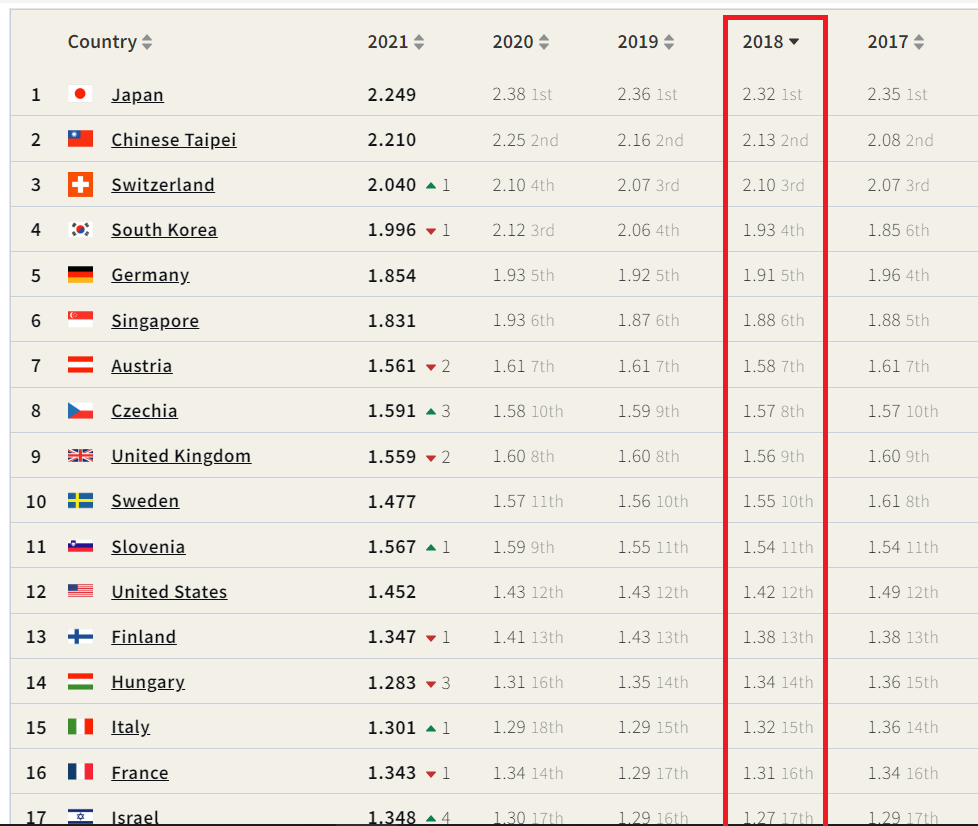

In [14]:
from IPython import display
display.Image("https://i.imgur.com/CxJsjl1.png")

### Bottom Line
###### There might be something I overlooked. But as far as I know:
- The filters are the same and transformation are the same regarding the same year range
- The population data I got from UN should be accurate enough (I didn't go with the one from WDI because they didn't have Taiwan)
- I see 3 different results:
    - The precalculated results
    - the results I calculated
    - the results from the OEC
- The results on the github demo and the results on the OEC seem to match (although values are a bit different). It's important to note they are using data from the actual OEC platform on the demo (trade and population). Both resources are closed access
